### Sign Language Digits Classification using Passive Agressive Classifiers

#### Importing Necessary Imports

In [2]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

#### Utils

In [3]:
# function to save figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    PATH = os.getcwd()
    IMAGES_PATH = PATH + '/images'
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    return

In [4]:
# function for plotting confusion matrices
def plot_confusion(y_test,y_predict,name):
	cm = confusion_matrix(y_test, y_predict)
	class_names=[0,1,2,3,4,5,6,7,8,9]
	fig, ax = plt.subplots(figsize=(6,6))
	tick_marks = np.arange(len(class_names))
	plt.xticks(tick_marks, class_names)
	plt.yticks(tick_marks, class_names)
	sns.heatmap(pd.DataFrame(cm), annot=True, cmap="Purples" ,fmt='g')
	ax.xaxis.set_label_position("top")
	plt.tight_layout()
	plt.title('Confusion Matrix', y=1.1)
	plt.ylabel('Actual label')
	plt.xlabel('Predicted label')
	save_fig(name)
	plt.show()
	return

#### Ploting training data

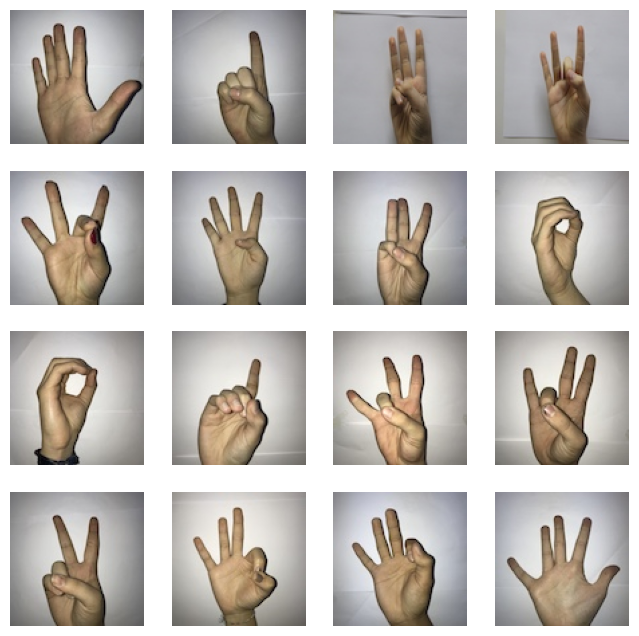

In [5]:
# ploting images from test
def plot_images(PATH):
  images = []
  for folder in os.listdir(PATH):
    for image in os.listdir(PATH + '/' + folder):
      images.append(os.path.join(PATH, folder, image))

  plt.figure(1, figsize=(8, 8))
  n = 0
  for i in range(16):
    n += 1
    random_img = random.choice(images)
    imgs = plt.imread(random_img)
    plt.subplot(4, 4,n)
    plt.axis('off')
    plt.imshow(imgs)
  plt.show()

# make sure you are pointing to train dir
os.chdir('../')
PATH = os.getcwd() + '/dataset/train'
plot_images(PATH)

#### Converting Images to Numpy Arrays

In [7]:
# converting images to numpy arrays 

from matplotlib.pyplot import imread
from skimage.transform import resize
img_size = 64
grayscale_images = True
num_class = 10
test_size = 0.2

# function to read individual images 
def get_img(data_path):
    img = imread(data_path)
    img = resize(img, (img_size, img_size, 1 if grayscale_images else 3))
    return img

# make sure path pints to the dataset containing 0-9 folders
def get_dataset(dataset_path='dataset'):
    try:
        X = np.load('npy_dataset/X.npy')
        Y = np.load('npy_dataset/Y.npy')
        X_test = np.load('npy_dataset/X_test.npy')
        Y_test = np.load('npy_dataset/Y_test.npy')
    except:
        labels = ['0','1','2','3','4','5','6','7','8','9']
        X = []
        Y = []
        X_test = []
        Y_test = []
        for i, label in enumerate(labels):
            datas_path = dataset_path+'/'+label
            var = 15
            for data in os.listdir(datas_path):
                img = get_img(datas_path+'/'+data)
                if(var==0):
                    X.append(img)
                    Y.append(i)
                else:
                    X_test.append(img)
                    Y_test.append(i)
                    var= var-1

        X = np.array(X).astype('float32')
        Y = np.array(Y).astype('float32')
        Y = to_categorical(Y, num_class)
        X_test = np.array(X_test).astype('float32')
        Y_test = np.array(Y_test).astype('float32')
        Y_test = to_categorical(Y_test, num_class)
        if not os.path.exists('npy_dataset/'):
            os.makedirs('npy_dataset/')
        np.save('npy_dataset/X.npy', X)
        np.save('npy_dataset/Y.npy', Y)
        np.save('npy_dataset/X_test.npy', X_test)
        np.save('npy_dataset/Y_test.npy', Y_test)
    return X, Y, X_test, Y_test

os.chdir('sign_lang_digits')
x, y,x_, y_ = get_dataset(dataset_path=os.getcwd()+'/dataset')


In [8]:
print("X shape :", x.shape)
print("Y shape :", y.shape)

print("X test shape :", x_.shape)
print("y tset dtype :", y_.shape)

X shape : (1912, 64, 64, 1)
Y shape : (1912, 10)
X test shape : (150, 64, 64, 1)
y tset dtype : (150, 10)


#### Data Preprocessing

In [9]:
# preprocessing data
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

y = np.argmax(y, axis=1)
X = x.reshape(x.shape[0],x.shape[1]*x.shape[2]) 
X = ss.fit_transform(X)

y_ = np.argmax(y_, axis=1)
x_ = x_.reshape(x_.shape[0],x_.shape[1]*x_.shape[2]) 
x_ = ss.fit_transform(x_)

#### Creating Classifiers

In [10]:
# loading two variants of PAC
from sklearn.linear_model import PassiveAggressiveClassifier

classifiers = [
    ("Passive-Aggressive I",
        PassiveAggressiveClassifier(max_iter=1000, loss="hinge", C=1.0, tol=1e-4),
    ),
    ("Passive-Aggressive II",
        PassiveAggressiveClassifier(
            max_iter=1000, loss="squared_hinge", C=1.0, tol=1e-4
        ),
    ),
  ]

#### Training Classifiers

Training Passive-Aggressive I
Training Passive-Aggressive II
Saving figure pac_train


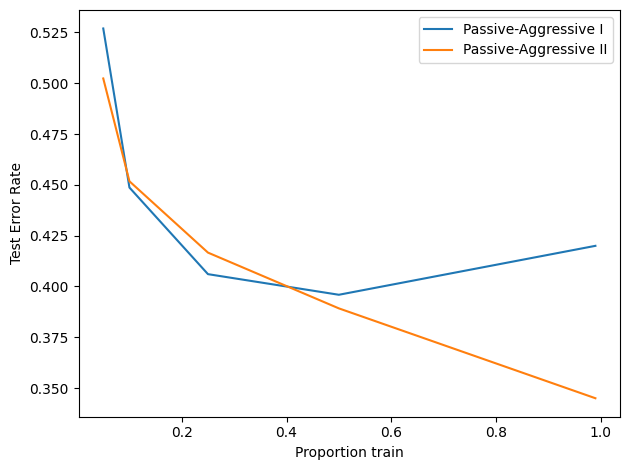

In [11]:
# training above classifiers on different train test splits

from sklearn.model_selection import train_test_split
heldout = [0.95, 0.90, 0.75, 0.50, 0.01]
rounds = 10
xx = 1.0 - np.array(heldout)

for name, clf in classifiers:
    print("Training %s" % name)
    yy = []
    for i in heldout:
        yy_ = []
        for r in range(rounds):
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=i
            )
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            yy_.append(1 - np.mean(y_pred == y_test))
        yy.append(np.mean(yy_))
    plt.plot(xx, yy, label=name)

plt.legend(loc="upper right")
plt.xlabel("Proportion train")
plt.ylabel("Test Error Rate")
save_fig('pac_train')
plt.show()


In [18]:
# train best clf on 90:10 split

clf = PassiveAggressiveClassifier(max_iter=1000, loss="squared_hinge", C=1.0, tol=1e-4)
clf.fit(X, y)
print('Accuracy Score Train Set:',clf.score(X,y))

Accuracy Score Train Set: 1.0


##### Using K-fold Cross Validation

In [19]:
# basically checking how our model will perform on test set
from sklearn.model_selection import cross_val_score

cross_val_score(clf,X,y,cv=3)

array([0.60188088, 0.6577708 , 0.59811617])

#### Making Predictions

Saving figure pac_cm


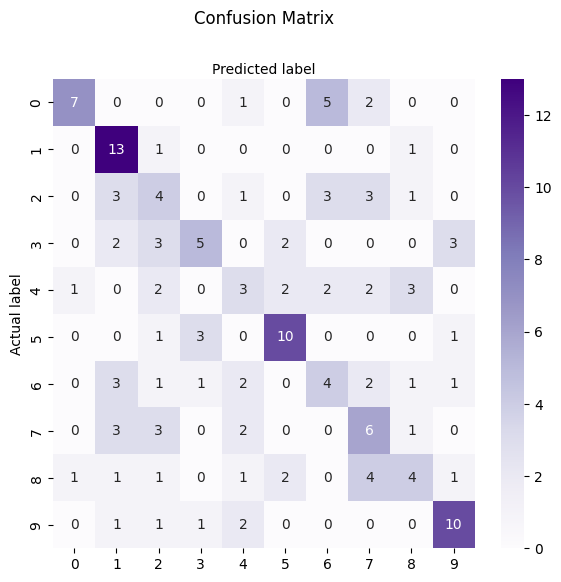

In [20]:
y_predict = clf.predict(x_)
plot_confusion(y_,y_predict, 'pac_cm')

In [21]:
from sklearn.metrics import precision_score, recall_score,f1_score

print('Accuracy Score Train Set:', clf.score(x_,y_))
print('Precesion Score :', precision_score(y_,y_predict,average='micro'))
print('Recall :', recall_score(y_,y_predict,average='micro'))
print('F1 Score :', f1_score(y_,y_predict,average='micro'))

Accuracy Score Train Set: 0.44
Precesion Score : 0.44
Recall : 0.44
F1 Score : 0.44


#### Saving Model

In [22]:
# saving model using pickle
import pickle

# change to models dir 
# os.chdir('models')
filename = 'pac.sav' 
pickle.dump(clf, open(filename, 'wb'))